<a href="https://colab.research.google.com/github/bytehub-ai/code-examples/blob/main/tutorials/02_bitcoin_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ByteHub Feature Store: Bitcoin price example

In [1]:
!pip install -q bytehub
!pip install -q pyarrow > 2

In [21]:
import pandas as pd
import numpy as np
import os
import shutil
import bytehub as bh
import requests
print(f'ByteHub version {bh.__version__}')

ByteHub version 0.2.3


In [18]:
# Remove any previously created feature stores
try:
    os.remove('bytehub.db')
except FileNotFoundError:
    pass
try:
    shutil.rmtree('/tmp/featurestore/tutorial')
except FileNotFoundError:
    pass

Create a new featurestore - this will be stored in a local sqlite database named `bytehub.db`.

In [19]:
fs = bh.FeatureStore()

Next, create a namespace called `tutorial` to store some features in. Edit the url field to specify a local file storage location that you would like to use. Feature values will be saved within this folder using parquet format.

In [20]:
fs.create_namespace(
    'tutorial', url='/tmp/featurestore/tutorial', description='Tutorial datasets'
)

Get some Bitcoin price data from the [CoinDesk API](https://www.coindesk.com/coindesk-api).

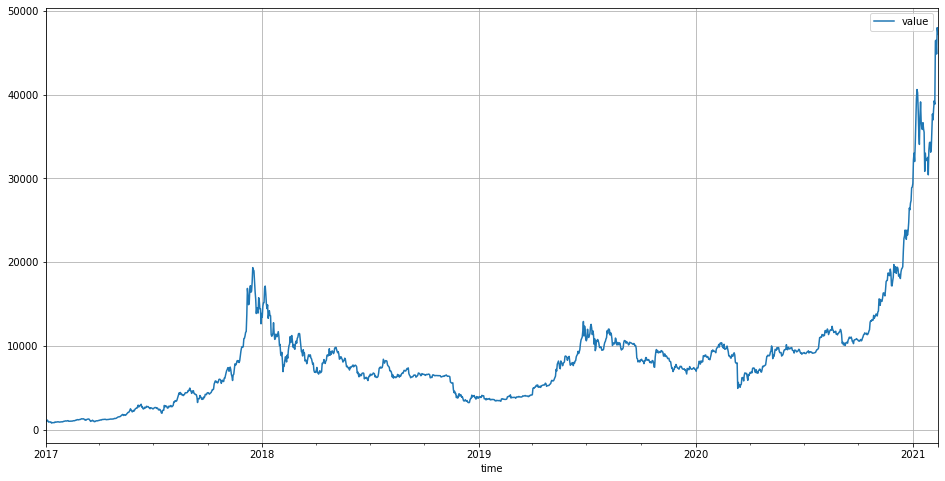

In [54]:
from_date = '2017-01-01'
to_date = pd.Timestamp.now().strftime('%Y-%m-%d')

response = requests.get(
  'https://api.coindesk.com/v1/bpi/historical/close.json',
  params={'start': from_date, 'end': to_date}
)
response.raise_for_status()

df_close = pd.DataFrame(
  {
    'time': pd.to_datetime(list(response.json().get('bpi').keys())),
    'value': response.json().get('bpi').values()
  }
).set_index('time')

_ = df_close.plot(figsize=(16, 8), grid=True)

Now create a feature and save it to the feature store.

In [34]:
fs.create_feature('tutorial/bitcoin.close', partition='year') # Data is partitioned by year on disk
fs.save_dataframe(df_close, 'tutorial/bitcoin.close')

Now engineer some new features. Compute the exponential weighted moving average of the bitcoin price data. Then take the difference as an indication of price momentum.

In [48]:
@fs.transform('tutorial/bitcoin.ewma.15', from_features=['tutorial/bitcoin.close'])
def ewma_15(df):
  return df.ewm(halflife=15).mean()

@fs.transform('tutorial/bitcoin.ewma.30', from_features=['tutorial/bitcoin.close'])
def ewma_30(df):
  return df.ewm(halflife=30).mean()

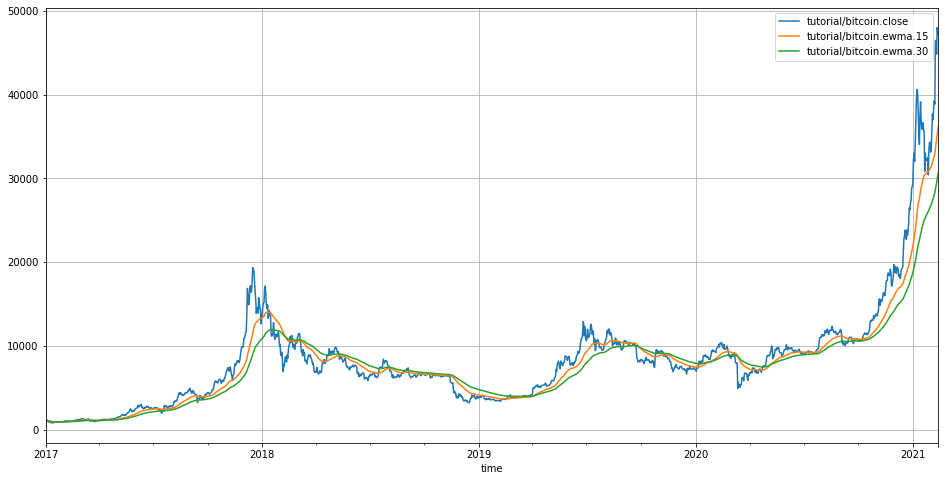

In [53]:
df_averages = fs.load_dataframe(['tutorial/bitcoin.close', 'tutorial/bitcoin.ewma.15', 'tutorial/bitcoin.ewma.30'])
_ = df_averages.plot(figsize=(16, 8), grid=True)

In [50]:
@fs.transform('tutorial/bitcoin.momentum', from_features=['tutorial/bitcoin.ewma.15', 'tutorial/bitcoin.ewma.30'])
def ewma_15(df):
  return df['tutorial/bitcoin.ewma.15'] - df['tutorial/bitcoin.ewma.30']

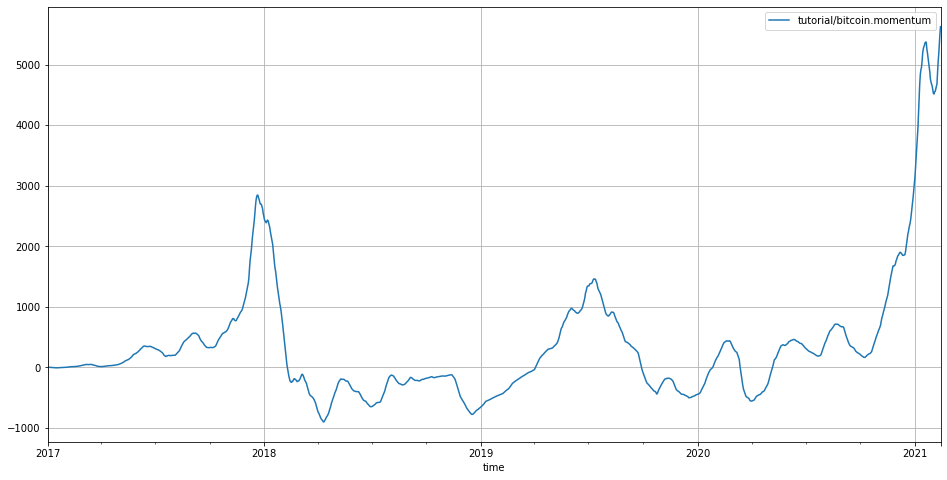

In [52]:
df_momentum = fs.load_dataframe(['tutorial/bitcoin.momentum'])
_ = df_momentum.plot(figsize=(16, 8), grid=True)